In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import keras

import bayesflow as bf

## Setup

In [3]:
two_moons = bf.benchmarks.TwoMoons()

In [4]:
num_train_simulations = 2048
num_val_simulations = 300
batch_size = 256
epochs = 1000

In [5]:
train_dataset = bf.datasets.OfflineDataset(two_moons.sample(num_train_simulations), batch_size=batch_size)
val_dataset = bf.datasets.OfflineDataset(two_moons.sample(num_val_simulations), batch_size=100)

In [6]:
inference_network = bf.networks.FlowMatching(subnet='mlp', subnet_kwargs=dict(depth=6))

approximator = bf.Approximator(
    inference_network=inference_network,
    inference_variables=["parameters"],
    inference_conditions=["observables"],
)

In [7]:
learning_rate = keras.optimizers.schedules.CosineDecay(1e-3, epochs * train_dataset.num_batches, 1e-6)

In [8]:
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate,
    global_clipnorm=1.0,
)

In [9]:
approximator.compile(optimizer=optimizer)

## Training

In [10]:
fit_history = approximator.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.8950 - val_loss: 0.6116
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6094 - val_loss: 0.6503
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5812 - val_loss: 0.4735
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4622 - val_loss: 0.3844
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4356 - val_loss: 0.4050
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4409 - val_loss: 0.3978
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4219 - val_loss: 0.4235
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3792 - val_loss: 0.3703
Epoch 9/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3971 - val_loss: 0.4822
Epoch 10/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4096 - val_loss: 0.4354
Epoch 11/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4212 - val_loss: 0.4506
Epoch 12/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3365 - val_loss: 0.2902
Epoch 70/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3433 - val_loss: 0.4223
Epoch 71/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3518 - val_loss: 0.4331
Epoch 72/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3394 - val_loss: 0.3178
Epoch 73/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3481 - val_loss: 0.3442
Epoch 74/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3360 - val_loss: 0.3002
Epoch 75/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3727 - val_loss: 0.3538
Epoch 76/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3522 - val_loss: 0.3490
Epoch 77/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3800 - val_loss: 0.3590
Epoch 78/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3599 - val_loss: 0.4264
Epoch 79/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3273 - val_loss: 0.3999
Epoch 80/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3684 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3575 - val_loss: 0.4453
Epoch 138/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3375 - val_loss: 0.3496
Epoch 139/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3612 - val_loss: 0.3785
Epoch 140/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3364 - val_loss: 0.4005
Epoch 141/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3323 - val_loss: 0.3095
Epoch 142/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3285 - val_loss: 0.3007
Epoch 143/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3348 - val_loss: 0.3919
Epoch 144/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3299 - val_loss: 0.4232
Epoch 145/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3188 - val_loss: 0.3917
Epoch 146/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3336 - val_loss: 0.4120
Epoch 147/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3018 - val_loss: 0.3717
Epoch 148/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3122 - val_loss: 0.4087
Epoch 205/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3600 - val_loss: 0.3209
Epoch 206/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3031 - val_loss: 0.3553
Epoch 207/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3299 - val_loss: 0.4007
Epoch 208/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3457 - val_loss: 0.3382
Epoch 209/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3124 - val_loss: 0.3091
Epoch 210/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3247 - val_loss: 0.3010
Epoch 211/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3165 - val_loss: 0.3314
Epoch 212/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3159 - val_loss: 0.3655
Epoch 213/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3025 - val_loss: 0.4144
Epoch 214/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3196 - val_loss: 0.5283
Epoch 215/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3290 - val_loss: 0.3261
Epoch 272/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3269 - val_loss: 0.3740
Epoch 273/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3361 - val_loss: 0.3862
Epoch 274/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3241 - val_loss: 0.2849
Epoch 275/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3281 - val_loss: 0.2741
Epoch 276/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3422 - val_loss: 0.3720
Epoch 277/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3624 - val_loss: 0.3111
Epoch 278/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3276 - val_loss: 0.3182
Epoch 279/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3413 - val_loss: 0.3311
Epoch 280/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3353 - val_loss: 0.3532
Epoch 281/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3256 - val_loss: 0.3707
Epoch 282/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3203 - val_loss: 0.2743
Epoch 339/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3276 - val_loss: 0.2558
Epoch 340/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3216 - val_loss: 0.3408
Epoch 341/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3144 - val_loss: 0.2768
Epoch 342/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3081 - val_loss: 0.4355
Epoch 343/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3079 - val_loss: 0.2992
Epoch 344/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3500 - val_loss: 0.3487
Epoch 345/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3089 - val_loss: 0.3014
Epoch 346/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3314 - val_loss: 0.3275
Epoch 347/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3064 - val_loss: 0.3490
Epoch 348/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3109 - val_loss: 0.3237
Epoch 349/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3156 - val_loss: 0.2367
Epoch 406/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3090 - val_loss: 0.3768
Epoch 407/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3271 - val_loss: 0.2414
Epoch 408/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3280 - val_loss: 0.3561
Epoch 409/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3059 - val_loss: 0.3554
Epoch 410/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3125 - val_loss: 0.2998
Epoch 411/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3331 - val_loss: 0.3555
Epoch 412/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3241 - val_loss: 0.3216
Epoch 413/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3190 - val_loss: 0.3777
Epoch 414/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3188 - val_loss: 0.3234
Epoch 415/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3057 - val_loss: 0.3042
Epoch 416/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2948 - val_loss: 0.2806
Epoch 473/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3083 - val_loss: 0.3441
Epoch 474/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2969 - val_loss: 0.2778
Epoch 475/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2996 - val_loss: 0.3242
Epoch 476/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3107 - val_loss: 0.3268
Epoch 477/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3129 - val_loss: 0.3467
Epoch 478/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2976 - val_loss: 0.2644
Epoch 479/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3384 - val_loss: 0.3341
Epoch 480/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2974 - val_loss: 0.4237
Epoch 481/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3274 - val_loss: 0.2985
Epoch 482/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3040 - val_loss: 0.3304
Epoch 483/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3461 - val_loss: 0.2819
Epoch 540/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3142 - val_loss: 0.3854
Epoch 541/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3317 - val_loss: 0.3214
Epoch 542/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2944 - val_loss: 0.3142
Epoch 543/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2917 - val_loss: 0.2705
Epoch 544/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3232 - val_loss: 0.2862
Epoch 545/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3015 - val_loss: 0.2705
Epoch 546/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3139 - val_loss: 0.3165
Epoch 547/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3538 - val_loss: 0.3290
Epoch 548/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3369 - val_loss: 0.2991
Epoch 549/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3347 - val_loss: 0.3054
Epoch 550/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3445 - val_loss: 0.3110
Epoch 607/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2964 - val_loss: 0.2854
Epoch 608/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3109 - val_loss: 0.3281
Epoch 609/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3216 - val_loss: 0.3773
Epoch 610/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3022 - val_loss: 0.3161
Epoch 611/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2853 - val_loss: 0.3079
Epoch 612/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3263 - val_loss: 0.3213
Epoch 613/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3166 - val_loss: 0.2871
Epoch 614/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3143 - val_loss: 0.2524
Epoch 615/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3057 - val_loss: 0.3654
Epoch 616/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3062 - val_loss: 0.2931
Epoch 617/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2969 - val_loss: 0.3224
Epoch 674/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2898 - val_loss: 0.2817
Epoch 675/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2743 - val_loss: 0.2829
Epoch 676/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3127 - val_loss: 0.4493
Epoch 677/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3054 - val_loss: 0.2844
Epoch 678/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2933 - val_loss: 0.2526
Epoch 679/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2951 - val_loss: 0.3078
Epoch 680/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3236 - val_loss: 0.3751
Epoch 681/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3134 - val_loss: 0.2757
Epoch 682/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3418 - val_loss: 0.3398
Epoch 683/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2852 - val_loss: 0.3308
Epoch 684/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3030 - val_loss: 0.3348
Epoch 741/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2828 - val_loss: 0.3399
Epoch 742/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3186 - val_loss: 0.2766
Epoch 743/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3330 - val_loss: 0.3534
Epoch 744/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2991 - val_loss: 0.2752
Epoch 745/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3216 - val_loss: 0.2699
Epoch 746/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2971 - val_loss: 0.3730
Epoch 747/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2799 - val_loss: 0.2700
Epoch 748/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3168 - val_loss: 0.3045
Epoch 749/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2916 - val_loss: 0.3179
Epoch 750/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3006 - val_loss: 0.3532
Epoch 751/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3031 - val_loss: 0.2877
Epoch 808/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2836 - val_loss: 0.2337
Epoch 809/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2857 - val_loss: 0.4275
Epoch 810/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3096 - val_loss: 0.3393
Epoch 811/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3010 - val_loss: 0.3193
Epoch 812/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3276 - val_loss: 0.2359
Epoch 813/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3137 - val_loss: 0.3910
Epoch 814/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3105 - val_loss: 0.2598
Epoch 815/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2885 - val_loss: 0.3297
Epoch 816/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2876 - val_loss: 0.3049
Epoch 817/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2945 - val_loss: 0.3431
Epoch 818/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2801 - val_loss: 0.2664
Epoch 875/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2898 - val_loss: 0.3283
Epoch 876/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2903 - val_loss: 0.3132
Epoch 877/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2799 - val_loss: 0.3216
Epoch 878/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2888 - val_loss: 0.2738
Epoch 879/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3091 - val_loss: 0.2690
Epoch 880/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3087 - val_loss: 0.3408
Epoch 881/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3079 - val_loss: 0.4550
Epoch 882/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2823 - val_loss: 0.3219
Epoch 883/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2856 - val_loss: 0.4352
Epoch 884/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2811 - val_loss: 0.2226
Epoch 885/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3027 - val_loss: 0.3130
Epoch 942/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2939 - val_loss: 0.2988
Epoch 943/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2962 - val_loss: 0.3160
Epoch 944/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2891 - val_loss: 0.2844
Epoch 945/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2993 - val_loss: 0.3345
Epoch 946/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3062 - val_loss: 0.2925
Epoch 947/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2949 - val_loss: 0.2691
Epoch 948/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3149 - val_loss: 0.3284
Epoch 949/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2779 - val_loss: 0.3699
Epoch 950/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3079 - val_loss: 0.2913
Epoch 951/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2886 - val_loss: 0.3833
Epoch 952/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - los

In [11]:
## Plot losses

## Validation

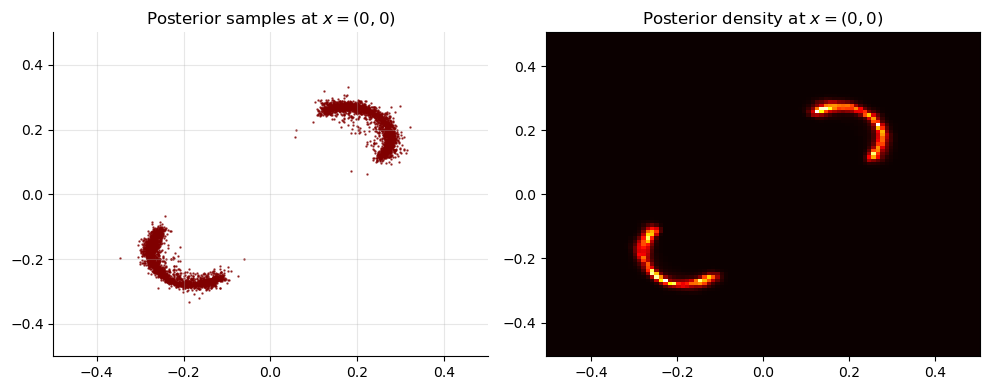

In [12]:
# Set the number of posterior draws you want to get
num_samples = 5000

# Prepare figure
f, axarr = plt.subplots(1, 2, figsize=(10, 4))

# Obtain amortized samples
obs_data = np.zeros((1, 2)).astype(np.float32)
samples = approximator.sample(num_samples=num_samples, data={"observables": obs_data}, numpy=True)

# Plot samples
axarr[0].scatter(samples["parameters"][:, 0], samples["parameters"][:, 1], color="maroon", alpha=0.75, s=0.5)
sns.despine(ax=axarr[0])
axarr[0].set_title(r"Posterior samples at $x=(0, 0)$")
axarr[0].grid(alpha=0.3)
axarr[0].set_xlim([-0.5, 0.5])
axarr[0].set_ylim([-0.5, 0.5])

# Compute log density on relevant posterior range
side = np.linspace(-0.5, 0.5, 100)
x, y = np.meshgrid(side, side)
obs_data_rep = np.zeros((10000, 2)).astype(np.float32)
params = np.c_[x.flatten(), y.flatten()]
lpdf = inference_network.log_prob(params, obs_data_rep)

# # Plot the density map using nearest-neighbor interpolation
axarr[1].pcolormesh(x, y, np.exp(lpdf).reshape(100, 100), cmap=cm.hot)
axarr[1].set_title(r"Posterior density at $x=(0, 0)$")

f.tight_layout()